In [299]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import stats
import scipy 

%matplotlib inline  

#Reading data
objs = dict(zip(['Var{}'.format(i) for i in range(191, 231)], ['object' for i in range(191, 231)]))
df = pd.read_csv('data/orange_small_train.data', sep='\t', dtype=objs)
# categData = df.iloc[:, 190:230]
# numData = df.iloc[:, 0:190]

Y_churn = np.loadtxt('data/orange_small_train_churn.labels')
Y_appet = np.loadtxt('data/orange_small_train_appetency.labels')
Y_upsell = np.loadtxt('data/orange_small_train_upselling.labels')

(50000, 230)


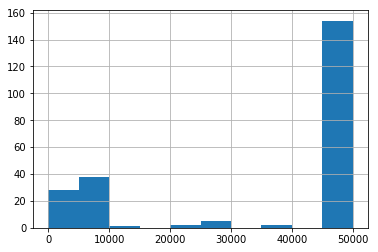

In [300]:
# missing values
df.isna().sum().hist();
print(df.shape)

In [301]:
#delete columns with missing values above 30%
treshold = 0.3
valid_columns = dict(df.isna().sum() < treshold * df.shape[0]) 
df = df[list([i for i in valid_columns if valid_columns[i] == True])] 
df.shape

(50000, 67)

In [302]:
numData = df[[i for i in list(df.columns) if i not in objs]]
catData = df[[i for i in list(df.columns) if i in objs]]

numData.shape, catData.shape

#change NaN`s by mean of the column in numerical
numData.fillna(numData.mean(), inplace=True)

#add label 'missing' in place of NaN`s in categorical 
catData.fillna('missing', inplace=True)


/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/rh/rh-python35/root/usr/lib64/python3.5/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


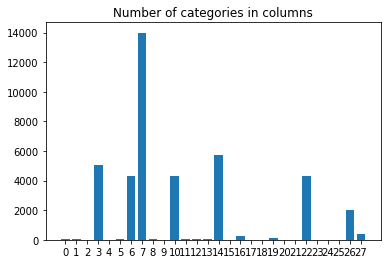

(50000, 19)

In [303]:
catCount = []
columsToExclude = {}
for col in catData.columns:
    catCount.append(catData[col].unique().size)
    if catData[col].unique().size > 100:
        columsToExclude[col] = False
        
plt.title('Number of categories in columns')
plt.xticks(range(len(catCount)))
plt.bar(range(len(catCount)), catCount)
plt.show()

# exclude columns with over 100 cat`s
catData = catData[list([i for i in catData.columns if i not in columsToExclude])]
catData.shape

In [304]:
z = np.abs(stats.zscore(numData))
stdThresh = 3.5
numData = numData[(z < stdThresh).all(axis=1)]
catData = catData[(z < stdThresh).all(axis=1)]
Y_churn = Y_churn[(z < stdThresh).all(axis=1)]
Y_appet = Y_appet[(z < stdThresh).all(axis=1)]
Y_upsell = Y_upsell[(z < stdThresh).all(axis=1)]

numData.shape, catData.shape, Y_churn.shape, Y_appet.shape, Y_upsell.shape

((40895, 39), (40895, 19), (40895,), (40895,), (40895,))

In [305]:
#OHE cat columns
enc = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()
for i in catData.columns:
    catData[i] = enc.fit_transform(catData[i])

catData_sparse = ohe.fit_transform(catData)

#stack numeric and cat columns
numData = preprocessing.minmax_scale(numData)
numData_sparse = pd.DataFrame(numData).to_sparse()
X = scipy.sparse.hstack(blocks = [numData_sparse, catData_sparse])

X

<40895x446 sparse matrix of type '<class 'numpy.float64'>'
	with 1921335 stored elements in COOrdinate format>

In [324]:
pickle.dump(X, open( "data_prepared/X.pkl", "wb" ))
pickle.dump(Y_churn, open( "data_prepared/Y_churn.pkl", "wb" ))
pickle.dump(Y_appet, open( "data_prepared/Y_appet.pkl", "wb" ))
pickle.dump(Y_upsell, open( "data_prepared/Y_upsell.pkl", "wb" ))

## Model Selection

In [319]:
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier